In [13]:
MODELPATH='' # path to save the model
MODELNAME=''
TrainPATH='/Train.csv'
TESTPATH='Test.csv'
VIDEOPATH='' # add path to the video containing folder
CNVSIZE=3900

In [14]:

import os
import torch
import pandas as pd
#from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils,models
from PIL import Image
import PIL
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import sys
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import cv2

plt.ion()   # interactive mode
np.set_printoptions(threshold=sys.maxsize)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        #transforms.RandomHorizontalFlip(),
        #transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

regress_data_transforms = {
    'train': transforms.Compose([
        #transforms.ToPILImage(),                        
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



In [20]:
class StackedFramesDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file listing all the folders in the datasets
            root_dir (string): Directory with all the csvs of images.        //ResnetData//images
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.markupcsv = pd.read_csv(csv_file)
        self.markup= self.markupcsv["VideoFile"].values
        self.labels=self.markupcsv["HBLevel"].values
       
        self.root_dir = root_dir
        self.transform = transform
       
    def __len__(self):

       return len(self.markup)
    def __getitem__(self, idx):
            
        datapoint=None
        flag=0
        #
        videoindex_to_read=idx
        video_to_read=self.root_dir+self.markup[videoindex_to_read]
        print(video_to_read)
        capture = cv2.VideoCapture(video_to_read)  # open the video using OpenCV
        #print(capture)
        no_of_frame=int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
        print("No of frames from the video",no_of_frame )
       
        start=0 
        end=1300 #specify number of frames to read from the video
      
        print("start:",start," End:",end)
        frame = start  # keep track of which frame we are up to, starting from start
        saved_count = 0  # a count of how many frames we have saved
        framecount=0 # this will keep track of the depth of each image
        capture.set(1, start)  # set the starting frame of the capture
        while frame < end:

            _, image = capture.read()
            image=Image.fromarray((image).astype(np.uint8))
            image=self.transform(image)  
            
            if(flag==0):
            
                flag=1;
                datapoint=image
            else:
           
            
                datapoint=np.concatenate([datapoint,image],axis=0) #stack frames in Z-axis

            frame=frame+1
          
        
        
        dp_Tensor=torch.Tensor(datapoint)
        
        #print("The output is below")
        print(datapoint.shape)
        dp_Tensor=torch.Tensor(datapoint)
        sample = (dp_Tensor, self.labels[videoindex_to_read])
         
        return sample


In [21]:
epoch_dict={}
import time
from time import ctime
import copy
def regress_train_model(model, criterion, optimizer, scheduler, num_epochs=40):
    since = time.time()
    start_time = ctime()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        epoch_since = time.time()
        model.train()  # Set model to training mode
        running_loss = 0.0            # Iterate over data.
        for inputs, labels in data_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)

         # zero the parameter gradients
          optimizer.zero_grad()
          with torch.set_grad_enabled(True):
            #print(":::::::::::::::::::Train:::::::::::::::::")
            outputs = model(inputs)
            loss = criterion(outputs.float(), labels.float())
            loss.backward()
            optimizer.step()               
            # statistics
            # print('{} loss item {:.4f} input size : {:d}', loss.item(), inputs.size(0))
          running_loss += loss.item() * inputs.size(0) 
        scheduler.step()

        epoch_loss = running_loss / len(data_loader.dataset)
        epoch_acc = 1 - epoch_loss

        print(' Loss: {:.4f} Acc: {:.4f}'.format(
                 epoch_loss, epoch_acc))
        epoch_dict[epoch]=epoch_loss

            # deep copy the model
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, os.path.join(MODELPATH, MODELNAME+str(epoch) + '.pth'))


        epoch_time_elapsed = time.time() - epoch_since
        print('Current epoch completed in {:.0f}m {:.0f}s'.format(
            epoch_time_elapsed // 60, epoch_time_elapsed % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    print(epoch_dict)
    return model


In [22]:
dataset = StackedFramesDataset(csv_file=TrainPATH,
                                    root_dir=VIDEOPATH,transform=regress_data_transforms['train'])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
data_loader = DataLoader(dataset,
                  batch_size=1)
net = models.resnet18(pretrained=False)
net = net.cuda() if device else net
net.conv1=nn.Conv2d(CNVSIZE, 64, kernel_size=7, stride=2, padding=3, bias=False) #update the first layer
'''inputs, curve_params = next(iter(data_loader))
print(curve_params)
print(inputs.shape)'''


Length of dataset  120
cuda:0


'inputs, curve_params = next(iter(data_loader))\nprint(curve_params)\nprint(inputs.shape)'

In [ ]:
#########################################################################################################################
#########################################################################################################################
# Put it all together
#########################################################################################################################
#########################################################################################################################
num_ftrs = net.fc.in_features
print(num_ftrs)

net.fc = nn.Linear(num_ftrs, 1)
net = net.to(device)
model_name = os.path.join('Model', "mymodal" + '.pth')
criterion = nn.MSELoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
net = regress_train_model(net, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)


512
Epoch 0/49
----------
videoindex_to_read:   0
2245-hareemfatima-june18.mp4
/content/drive/MyDrive/pathwell/PATHWELLDATA/Pathwell-Data-Orignal/2245-hareemfatima-june18.mp4
No of frames from the video 1898
start: 0  End: 1300
(3900, 224, 224)
videoindex_to_read:   1
1922-azanmqsood-1-june11.mp4
/content/drive/MyDrive/pathwell/PATHWELLDATA/Pathwell-Data-Orignal/1922-azanmqsood-1-june11.mp4
No of frames from the video 1893
start: 0  End: 1300
(3900, 224, 224)
videoindex_to_read:   2
2186-shafia-2.mp4
/content/drive/MyDrive/pathwell/PATHWELLDATA/Pathwell-Data-Orignal/2186-shafia-2.mp4
No of frames from the video 1898
start: 0  End: 1300
(3900, 224, 224)
videoindex_to_read:   3
1826-jumakhan-1-june9.mp4
/content/drive/MyDrive/pathwell/PATHWELLDATA/Pathwell-Data-Orignal/1826-jumakhan-1-june9.mp4
No of frames from the video 1872
start: 0  End: 1300


In [ ]:


'''
#########################################################################################################################
#########################################################################################################################
# Test Phase
#########################################################################################################################
#########################################################################################################################
'''


def test(model):
    print(model)
    model.eval()
    use_gpu = False
    dataset = StackedFramesDataset(csv_file='/home/humera/markup-females-test.csv',
                                   root_dir='/home/humera/videos/',
                                   transform=regress_data_transforms['train'])
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print("In test the device is:", device)
    test_data_loader = DataLoader(dataset,
                                  batch_size=1,
                                  num_workers=1)
    for data in test_data_loader:
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        # optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        print("________________________ Test Output__________________________")
        print("Actual Labels: ", labels )
        print("Prediction Output",outputs)
        print("__________________________________________________")



In [ ]:
test(net)

In [ ]:

x= epoch_dict.keys()
y=epoch_dict.values()
print(x)
print(y)


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])
dict_values([21.810815417426912, 5.2542299252989535, 5.006088390679317, 4.663215284126208, 4.6153725842013955, 4.47298484985881, 4.303402314181714, 3.776258765993749, 3.746988451217904, 3.739688528153826, 3.7308061735375837, 3.7227238016750883, 3.714580391698024, 3.7062709662405884, 3.6753155223148712, 3.5810883485657325, 3.5737637695582474, 3.5725822332589066, 3.5716211438617287, 3.5709064927171257, 3.569950125454103, 3.5596532076597214, 3.559588561382364, 3.5594840089187905, 3.5593656923841026, 3.5592579241184628, 3.559122079873786, 3.559027764507953, 3.5580222402863644, 3.558018160655218,

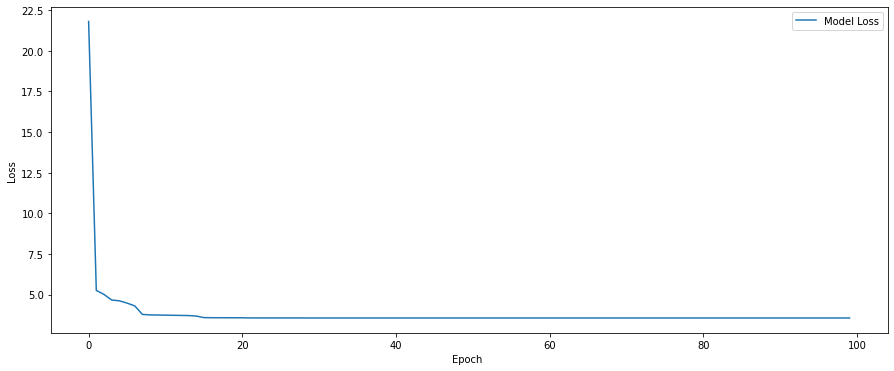

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(y, label="Model Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch ')
plt.legend()
plt.show()
plt.savefig('out.png', format = 'png', dpi=120)